# 23_04_25_08_erythroid_lineage_下游分析4_邻居图结构

> 参考: 

>   定义: 1. /mnt/h/F_bak/Python进阶/scRNA/Other/MyRNAVelocity/其他绘图/plot/draw_batch.py

>   调用: 2. /mnt/h/F_bak/Python进阶/scRNA/Other/MyRNAVelocity/其他绘图/23_03_27_10_scvelo在erythroid_lineage上的图构建与结果分析_重构.ipynb

In [1]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import anndata as ad
import scanpy as sc
import scvelo as scv
import velovgi

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from torch_geometric import seed_everything

seed = 0
seed_everything(seed)

## 1. 读取结果

In [3]:
# adata_dir = "tmp/erythroid_lineage/adata"
adata_dir = "tmp/erythroid_lineage2/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

## 2. 批次间弦图

1. 需要先可视化一下才有颜色

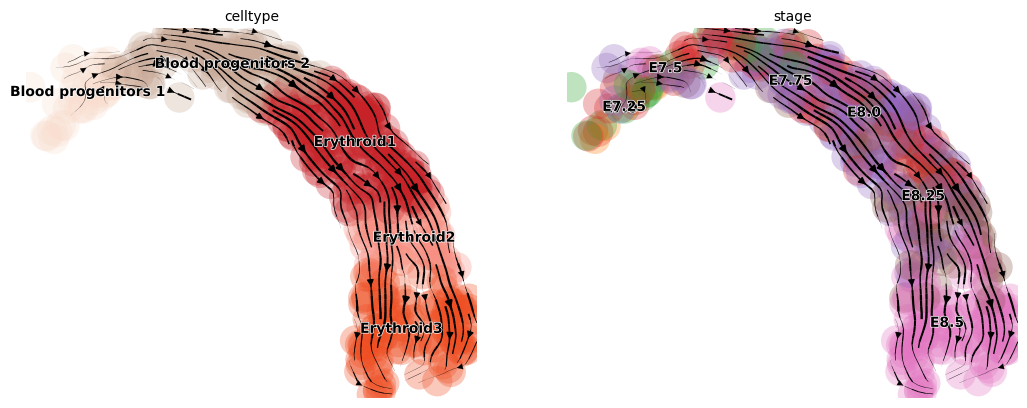

In [4]:
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key])

2. 弦图绘制定义

In [5]:
import numpy as np
import pandas as pd

# 添加了子图绘制的函数
def draw_batch_circos_ax(adata, batch_key="batch", ticks_interval=None, return_matrix_df=False, ax=None):
    from pycirclize import Circos
    
    # 提取边的数量
    row_names = list(adata.obs[batch_key].cat.categories)
    col_names = row_names
    matrix_data = np.zeros((len(row_names), len(col_names)))
    connectivities = adata.obsp["connectivities"]
    for i in range(len(row_names)):
        for j in range(len(col_names)):
            # if i > j:
            #     continue
            row_name = row_names[i]
            col_name = col_names[j]
            row_bool_series = adata.obs[batch_key] == row_name
            col_bool_series = adata.obs[batch_key] == col_name
            matrix_data[i,j] = (connectivities[row_bool_series,:][:,col_bool_series]>0).sum()
    matrix_data = matrix_data.astype("int")
    # matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

    # 添加细胞数目
    row_names = ["%s(%d)"%(row_name, (adata.obs[batch_key]==row_name).sum()) for row_name in row_names]
    col_names = row_names

    # 只保留上半部分矩阵
    adjust_matrix_data = np.zeros(matrix_data.shape)
    for i in range(matrix_data.shape[0]):
        for j in range(matrix_data.shape[0]):
            if i <= j:
                adjust_matrix_data[i][j] = matrix_data[i][j]
    adjust_matrix_df = pd.DataFrame(adjust_matrix_data, index=row_names, columns=col_names)

    # TODO: 这里自动提取计算ticks_interval
    if ticks_interval == None:
        base = 100 # 精确到指定位数上
        ticks_interval = int(adjust_matrix_df.sum().sum()/10/base)*base

    # 绘制
    circos = Circos.initialize_from_matrix(
        adjust_matrix_df,
        space=3,
        r_lim=(93, 100),
        cmap=dict(zip(row_names, adata.uns["%s_colors"%batch_key])),
        ticks_interval=ticks_interval,
        ticks_kws=dict(label_size=10),
        label_kws=dict(r=94, size=12, color="black"), # 暂时为了看清，只能设置为黑色了
    )

    fig = circos.plotfig(ax=ax)

    if return_matrix_df==True:
        return adjust_matrix_df

3. 执行

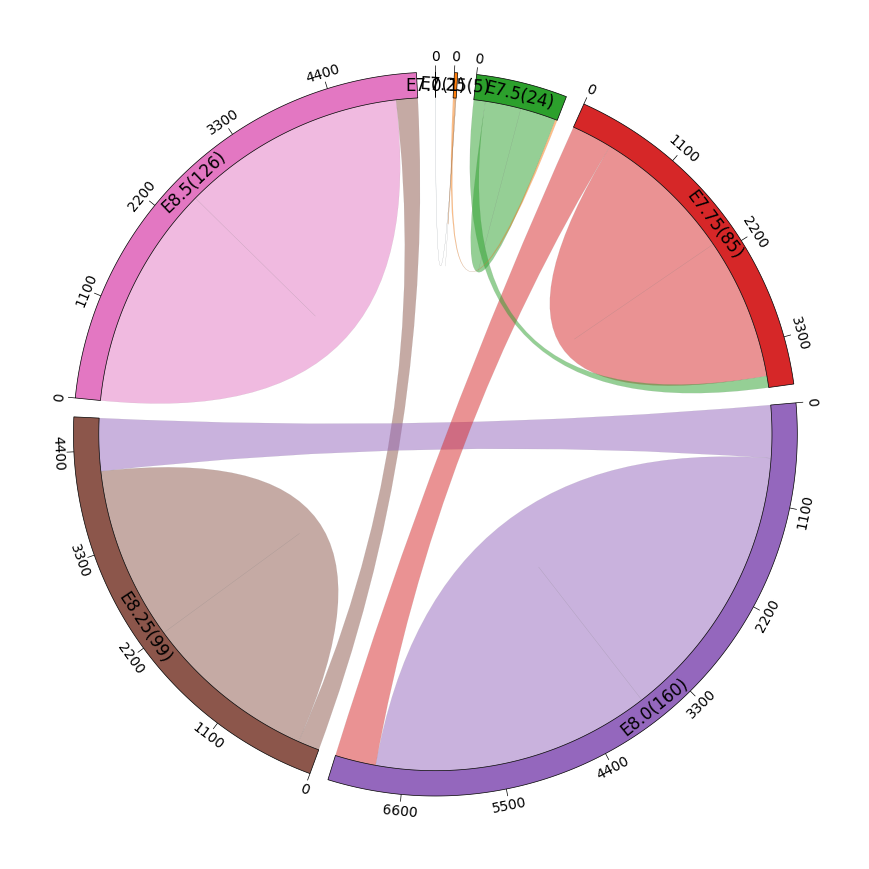

In [6]:
df = draw_batch_circos_ax(adata, batch_key, return_matrix_df=True)

## 3. 各个批次下的邻居数量分布

In [14]:
import matplotlib.pyplot as plt
get_mask = velovgi.pp.get_mask # 重命名函数

def draw_batch_nn_umap(adata, batch_key="batch", cluster_key="clusters", title="batch_nn_umap", save=None):
    array = adata.obs[batch_key]
    batch_list = list(adata.obs[batch_key].cat.categories)
    n = len(batch_list)
    batch_pair_list = []
    for i in range(n):
        for j in range(i,n):
            batch_pair_list.append([batch_list[i], batch_list[j]])
    knn_mask, bnn_mask = get_mask(array, batch_pair_list)
    # (knn_mask.T == knn_mask).any(), (bnn_mask.T == bnn_mask).any() # 两个mask矩阵都是对称的
    connectivities = adata.obsp["connectivities"]
    # print((connectivities.A.T == connectivities.A).all()) # 对称的邻居图
    # 提取两种邻居数目
    adata.obs["knn"] = (np.where(knn_mask == 1, connectivities.A, 0) > 0).sum(axis=0)
    adata.obs["bnn"] = (np.where(bnn_mask == 1, connectivities.A, 0) > 0).sum(axis=0)

    adata.obs["knn"] = adata.obs["knn"].astype("float")
    adata.obs["bnn"] = adata.obs["bnn"].astype("float")
    # scv.pl.umap(adata, color=["knn","bnn"])

    cols = 5  # 每行的umap图个数，最好是奇数
    n_batch_list = len(batch_list)
    cols = min(cols, n_batch_list)
    rows_per_group = int(np.ceil(n_batch_list / cols))
    cols_per_big_umap = int((cols+1)/2)
    rows = 2*rows_per_group + cols_per_big_umap  # 前面是小umap图，后面是大umap图
    figsize = ((cols+1)*4, rows*4)
    fig, ax = plt.subplots(rows,
                           cols+1,
                           num=title,
                           figsize=figsize,
                           tight_layout=True)
    # plt.ioff() # 暂时不直接显示，作为结果返回，这种延迟展示会有问题，之后一股脑地显示出来
    fig.suptitle(title, fontsize=30)

    #################################################### 整体UMAP部分####################################################
    tmp_ax = plt.subplot2grid((rows, cols+1), (0, 0),
                            colspan=cols_per_big_umap, rowspan=cols_per_big_umap)
    scv.pl.umap(adata, color=batch_key, ax=tmp_ax, show=False,
                frameon="artist", legend_loc="right margin")

    tmp_ax = plt.subplot2grid((rows, cols+1), (0, cols_per_big_umap),
                            colspan=cols_per_big_umap, rowspan=cols_per_big_umap)
    scv.pl.umap(adata, color=cluster_key, ax=tmp_ax, show=False,
                frameon="artist", legend_loc="right margin")


    #################################################### 小图UMAP部分####################################################
    # cmap = plt.get_cmap("viridis") # 统一配色
    cmap = plt.get_cmap("gnuplot")  # 统一配色
    size = 120000/adata.shape[0]  # 统一细胞大小
    # 设置colorbar
    neighbor_key = "knn"
    # vmax=adata.obs[neighbor_key].max()
    # vmin, vmax = adata.obs[neighbor_key].quantile([0.25,0.75]) # 上下四分位数
    vmin, vmax = adata.obs[neighbor_key].quantile([0.05, 0.95])  # 上下95分位数
    tmp_ax = ax[cols_per_big_umap][0]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    tmp_ax.set_aspect(1.0/(tmp_ax.get_data_ratio()),
                    adjustable="box")  # 设置子图到下边界的距离
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=tmp_ax, orientation="horizontal", fraction=0.5)
    cbar.set_label("%s\nmax=%s" % (neighbor_key, int(
        adata.obs[neighbor_key].max())), fontsize=30)
    for i in range(n_batch_list):
        batch = batch_list[i]
        adata_batch = adata[adata.obs[batch_key] == batch]
        row = int(i/cols)
        col = i % cols+1
        if col == 1 and row != 0:
            ax[row+cols_per_big_umap][0].axis("off")  # 清空边框刻度
        row += cols_per_big_umap
        tmp_ax = ax[row][col]
        scv.pl.umap(adata_batch,
                    color=neighbor_key,
                    show=False,
                    title="%s/%s/%s" % (neighbor_key, batch, adata_batch.shape[0]),
                    size=size,
                    vmin=0,
                    vmax=vmax,
                    colorbar=False,
                    frameon="artist",
                    cmap=cmap,
                    ax=tmp_ax)
        # 最后一行后面几列清空边框刻度
        if i == n_batch_list-1 and (not (col == cols-1)):
            for j in range(col+1, cols+1):
                ax[row][j].axis("off") 

    neighbor_key = "bnn"
    # vmax=adata.obs[neighbor_key].max()
    # vmin, vmax = adata.obs[neighbor_key].quantile([0.25,0.75]) # 上下四分位数
    vmin, vmax = adata.obs[neighbor_key].quantile([0.05, 0.95])  # 上下95分位数
    tmp_ax = ax[rows_per_group+cols_per_big_umap][0]
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    tmp_ax.set_aspect(1.0/(tmp_ax.get_data_ratio()),
                    adjustable="box")  # 设置子图到下边界的距离
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=tmp_ax, orientation="horizontal", fraction=0.5)
    cbar.set_label("%s\nmax=%s" % (neighbor_key, int(
        adata.obs[neighbor_key].max())), fontsize=30)
    for i in range(n_batch_list):
        batch = batch_list[i]
        adata_batch = adata[adata.obs[batch_key] == batch]
        row = int(i/cols)
        col = i % cols+1
        if col == 1 and row != 0:
            ax[row+rows_per_group+cols_per_big_umap][0].axis("off")  # 清空边框刻度
        row += rows_per_group+cols_per_big_umap
        tmp_ax = ax[row][col]
        scv.pl.umap(adata_batch,
                    color=neighbor_key,
                    show=False,
                    title="%s/%s/%s" % (neighbor_key, batch, adata_batch.shape[0]),
                    size=size,
                    vmin=0,
                    vmax=vmax,
                    colorbar=False,
                    frameon="artist",
                    cmap=cmap,
                    ax=tmp_ax)
        # 最后一行后面几列清空边框刻度
        if i == n_batch_list-1 and (not (col == cols-1)):
            for j in range(col+1, cols+1):
                ax[row][j].axis("off")
    
    if not save==None:
        fig.savefig(save, format = save.split(".")[-1] if "." in save else "png")
        plt.close(fig)
    return fig

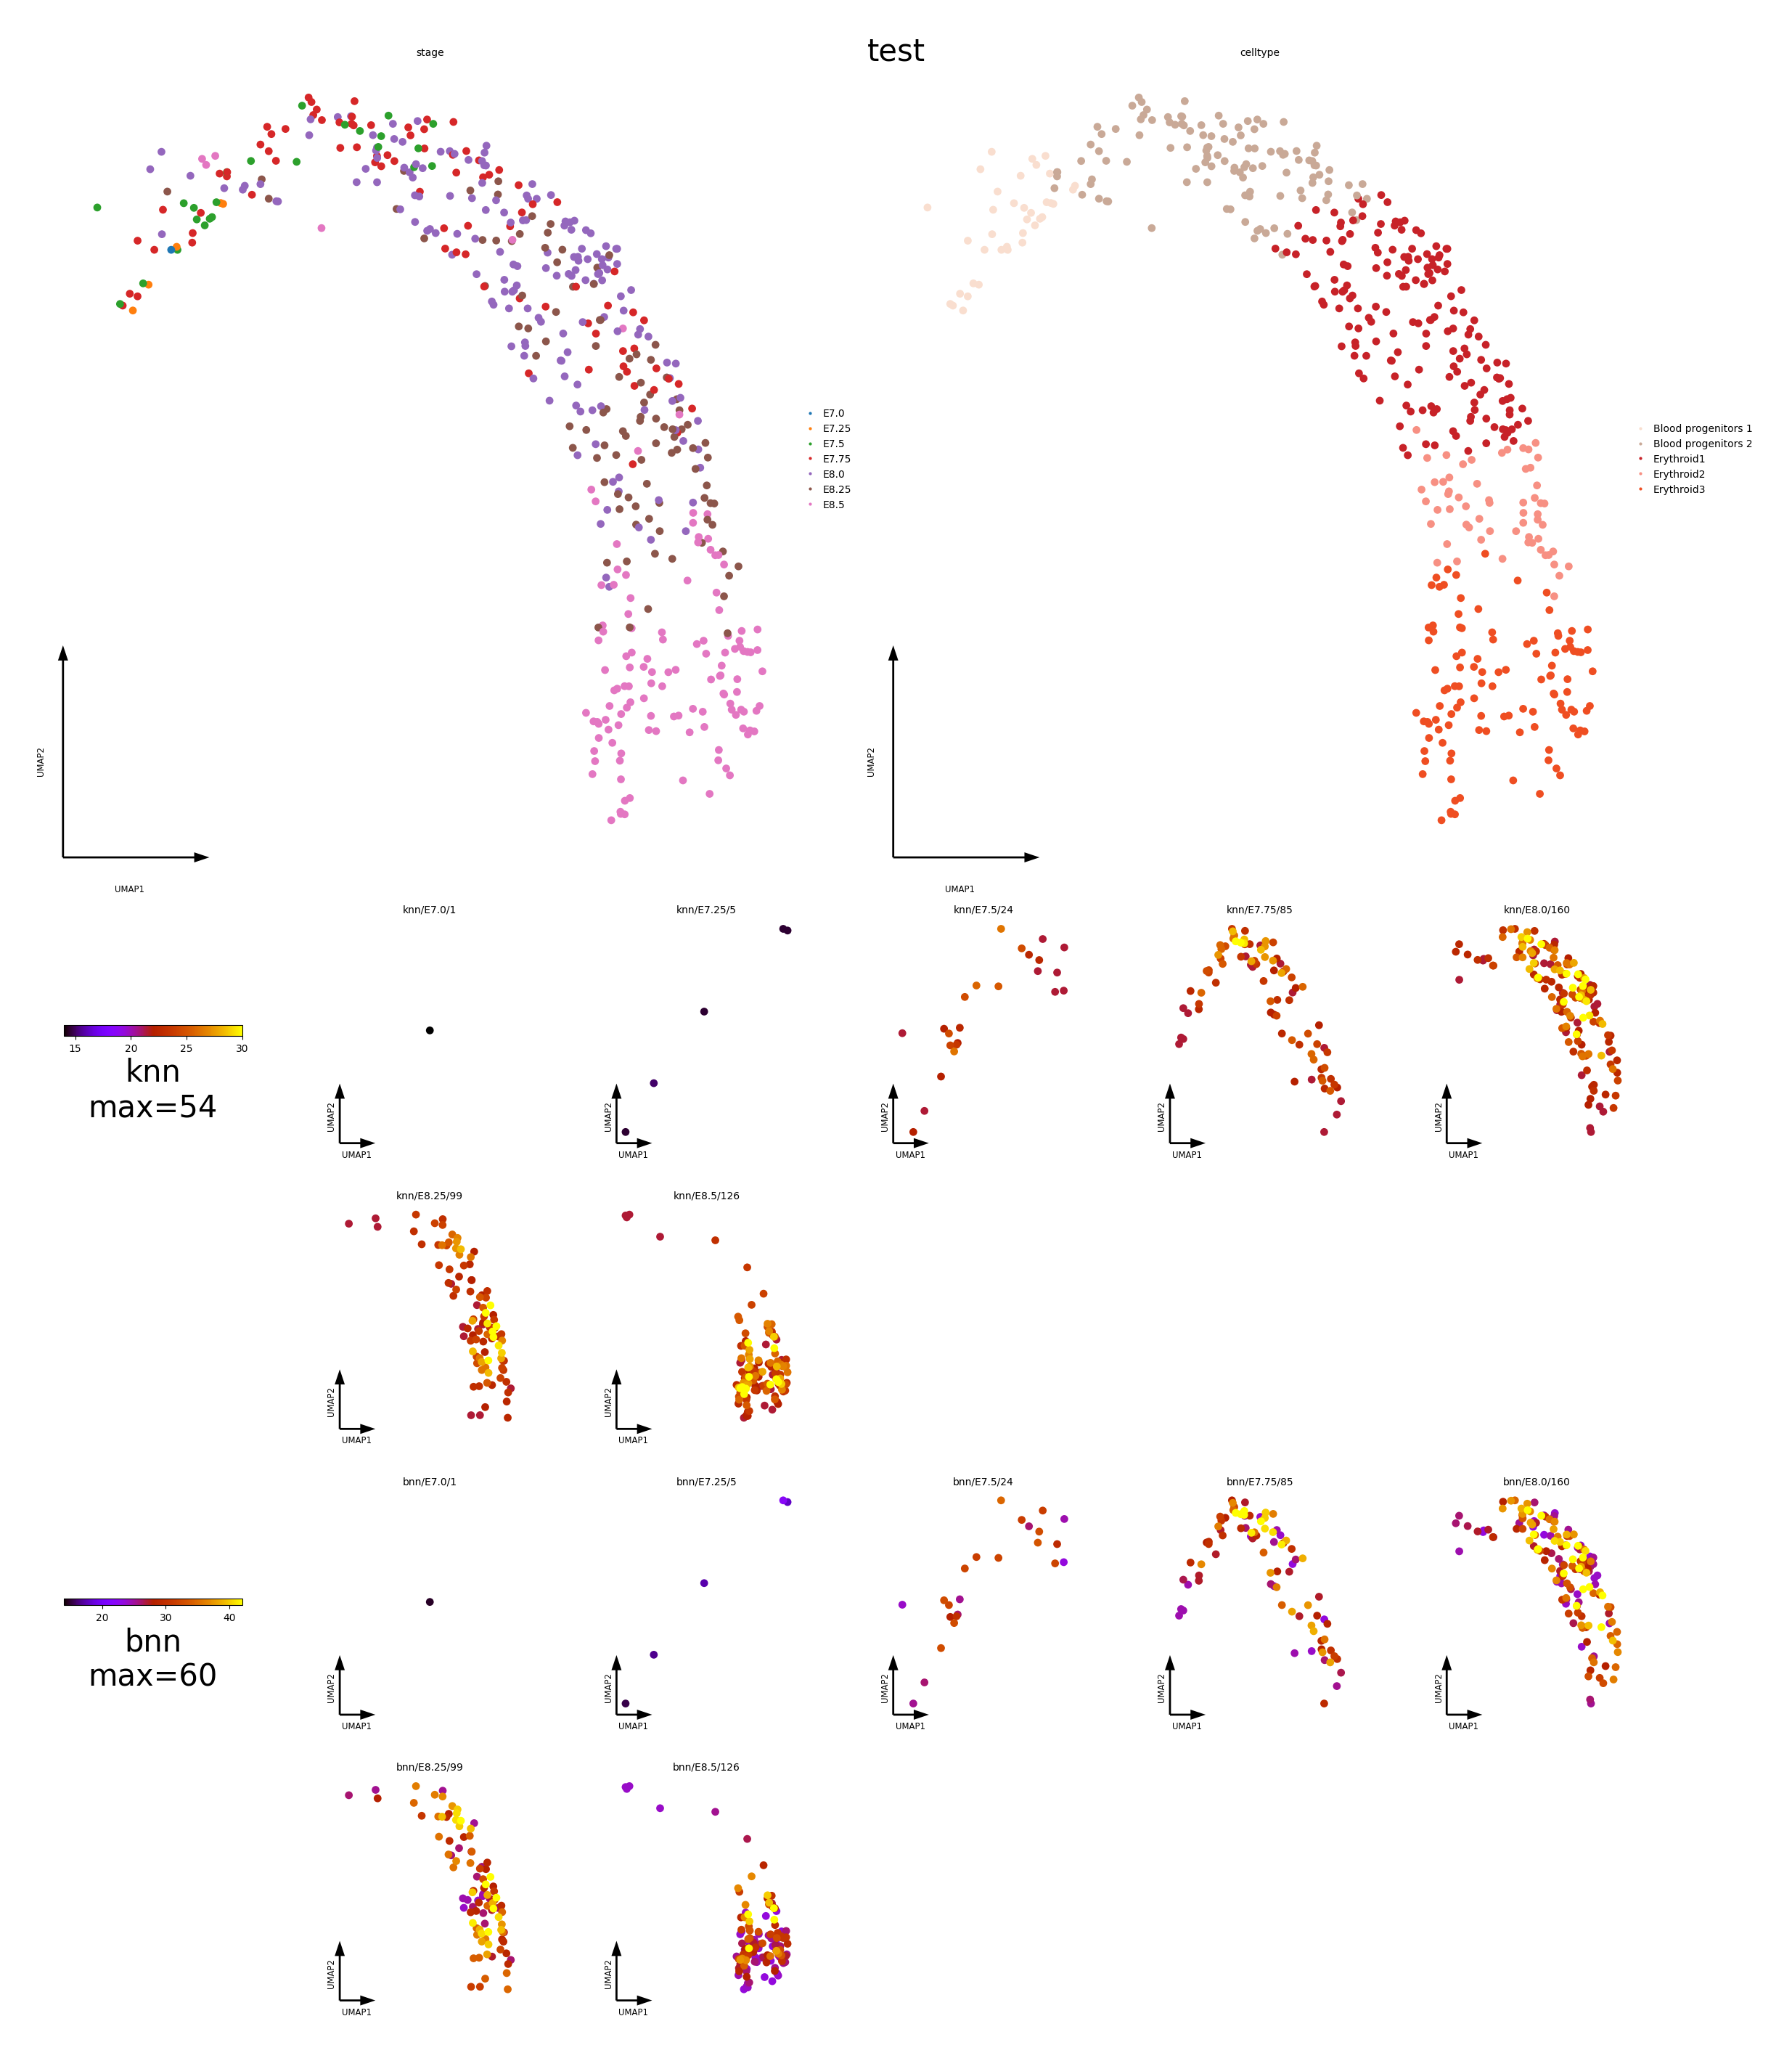

In [16]:
batch_nn_umap_fig = draw_batch_nn_umap(adata, batch_key=batch_key, cluster_key=cluster_key, title="test")